# Run ML models online

Now we take the trained models and run them in the climate model.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import climt
from climt._core import ensure_contiguous_state, bolton_q_sat
from climt._components.emanuel import _emanuel_convection
from sympl import (
    PlotFunctionMonitor,
    TimeDifferencingWrapper,
    DataArray,
    DiagnosticComponent,
    initialize_numpy_arrays_with_properties,
    NetCDFMonitor,
    TendencyComponent
)
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
# Necessary to supress annying matplotlib warnings
import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
import pickle
import xarray as xr
from functions import *
import tensorflow.keras as keras

In [3]:
with open('./state.pkl', 'rb') as f:
    my_state = pickle.load(f)

In [4]:
with open('norm_arrs.pkl', 'rb') as f:
    input_means, input_stds, output_means, output_stds = pickle.load(f)

## Create MLConvection class

In [50]:
class MLConvection(TendencyComponent):
    input_properties = {
        'air_temperature': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK',
        },
        'specific_humidity': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg',
        },
        'eastward_wind': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-1',
        },
        'northward_wind': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-1',
        },
        'air_pressure': {
            'dims': ['*', 'mid_levels'],
            'units': 'mbar',
        },
    }
    
    diagnostic_properties = {
        'convective_precipitation_rate': {
            'dims': ['*'],
            'units': 'mm day^-1',
        },
        'air_temperature_tendency_from_convection': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK s^-1',
        },
        'specific_humidity_tendency_from_convection': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg s^-1',
        },
        'eastward_wind_tendency_from_convection': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-2',
        },
        'northward_wind_tendency_from_convection': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-2',
        }
    }
    
    tendency_properties = {
        'air_temperature': {'units': 'degK s^-1'},
        'specific_humidity': {'units': 'kg/kg s^-1'},
        'eastward_wind': {'units': 'm s^-2'},
        'northward_wind': {'units': 'm s^-2'},
    }
    input_vars = ['air_temperature', 'specific_humidity', 'eastward_wind', 'northward_wind', 
              'air_pressure']
    output_vars = ['air_temperature', 'specific_humidity', 'eastward_wind', 'northward_wind',
               'convective_precipitation_rate']
    
    def __init__(self, model, input_means=None, input_stds=None, output_means=None, output_stds=None, **kwargs):
        self.model = model
        self.input_means, self.input_stds, self.output_means, self.output_stds = \
            input_means, input_stds, output_means, output_stds
        super().__init__(self, **kwargs)
        
    def array_call(self, state):
        # Allocate arrays
        tendencies = initialize_numpy_arrays_with_properties(
            self.tendency_properties, state, self.input_properties
        )
        diagnostics = initialize_numpy_arrays_with_properties(
            self.diagnostic_properties, state, self.input_properties
        )
        
        # Concat input dimension
        ncol, nz = state['air_temperature'].shape
        input_arr = []
        for var in input_vars:
            input_arr.append(state[var])
            if var == 'air_pressure': input_arr[-1] *= 100
        input_arr = np.concatenate(input_arr, 1)
        
        # Ugly check to see whether its a RF or NN
        if not input_means is None: 
            input_arr = normalize(input_arr, input_means, input_stds)
        if not hasattr(self.model, 'compile'):
            preds = self.model.predict(input_arr)
        else:
            preds = self.model.predict(input_norm, 10000)
        if not output_means is None:
            preds = unnormalize(preds, output_means, output_stds)
        
        # Split into tendencies
        tendencies['air_temperature'] = preds[:, :nz]
        tendencies['specific_humidity'] = preds[:, nz:nz*2]
        tendencies['eastward_wind'] = preds[:, nz*2:nz*3]
        tendencies['northward_wind'] = preds[:, nz*3:nz*4]
        diagnostics['air_temperature_tendency_from_convection'][:] = (
            tendencies['air_temperature'])
        diagnostics['specific_humidity_tendency_from_convection'][:] = (
            tendencies['specific_humidity'])
        diagnostics['eastward_wind_tendency_from_convection'][:] = (
            tendencies['eastward_wind'])
        diagnostics['northward_wind_tendency_from_convection'][:] = (
            tendencies['northward_wind'])
        diagnostics['convective_precipitation_rate'] = preds[:, -1]
        
        return tendencies, diagnostics

## Neural network

In [6]:
nn = keras.models.load_model('./nn1.h5')

W0814 14:47:05.206066 139871569515904 deprecation.py:506] From /home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 14:47:05.208105 139871569515904 deprecation.py:506] From /home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0814 14:47:05.209482 139871569515904 deprecation.py:506] From /home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ze

In [7]:
nn_convection = MLConvection(nn, input_means, input_stds, 0, output_stds)

In [8]:
regular_convection = climt.EmanuelConvection()

### Check predictions offline

In [9]:
nn_preds, _ = nn_convection(my_state)

In [10]:
truth, _ = regular_convection(my_state, timedelta(seconds=1800))

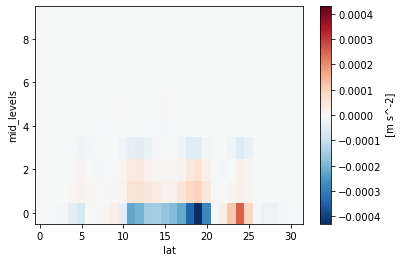

In [11]:
nn_preds['eastward_wind'].isel(lon=0).T.plot();

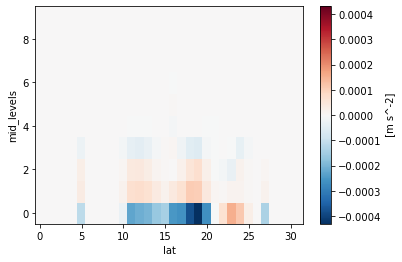

In [12]:
truth['eastward_wind'].isel(lon=0).T.plot();

### Run online

How I save the files (input/output) is a little stupid for these runs, but we will run with it for now.

In [13]:
!rm inputs_nn.nc outputs_nn.nc

In [14]:
nn_model = MyModel(
    state=my_state, 
    convection=nn_convection,
    input_save_fn='./inputs_nn.nc',
    output_save_fn='./outputs_nn.nc',
)

In [17]:
nn_model.iterate(48*180)

### Better neural network

In [15]:
nn2 = keras.models.load_model('./nn2.h5')

In [16]:
nn2_convection = MLConvection(nn2, input_means, input_stds, 0, output_stds)

In [81]:
nn2_model = MyModel(
    state=my_state, 
    convection=nn2_convection,
    input_save_fn='./inputs_nn2.nc',
    output_save_fn='./outputs_nn2.nc',
)

In [82]:
nn2_model.iterate(48*180)

## Random forest

In [17]:
with open('rf1.pkl', 'rb') as f:
    rf = pickle.load(f)

In [18]:
rf.verbose = 0
rf.n_jobs = None

In [19]:
rf_convection = MLConvection(rf)

In [20]:
regular_convection = climt.EmanuelConvection()

### Check predictions offline

In [21]:
%%time
rf_preds, _ = rf_convection(my_state)

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 16.7 ms


In [22]:
truth, _ = regular_convection(my_state, timedelta(seconds=1800))

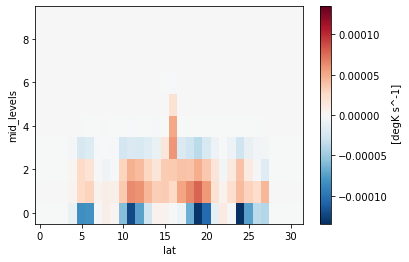

In [23]:
rf_preds['air_temperature'].isel(lon=0).T.plot();

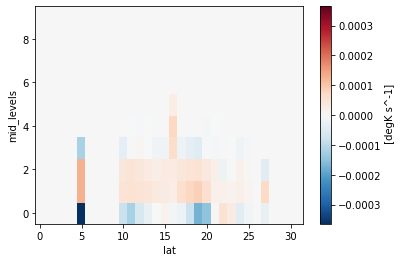

In [24]:
truth['air_temperature'].isel(lon=0).T.plot();

### Run online

How I save the files (input/output) is a little stupid for these runs, but we will run with it for now.

In [53]:
!rm inputs_rf.nc outputs_rf.nc

In [54]:
rf_model = MyModel(
    state=my_state, 
    convection=rf_convection,
    input_save_fn='./inputs_rf.nc',
    output_save_fn='./outputs_rf.nc',
)

In [55]:
rf_model.iterate(48*180)

## Linear regression

In [36]:
with open('lr.pkl', 'rb') as f:
    lr = pickle.load(f)

In [51]:
lr_convection = MLConvection(lr, input_means, input_stds, 0, output_stds)

In [52]:
regular_convection = climt.EmanuelConvection()

### Check predictions offline

In [53]:
%%time
lr_preds, _ = lr_convection(my_state)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 11.2 ms


In [54]:
truth, _ = regular_convection(my_state, timedelta(seconds=1800))

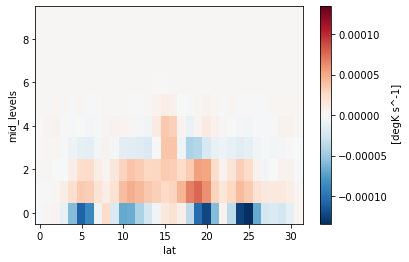

In [55]:
lr_preds['air_temperature'].isel(lon=0).T.plot();

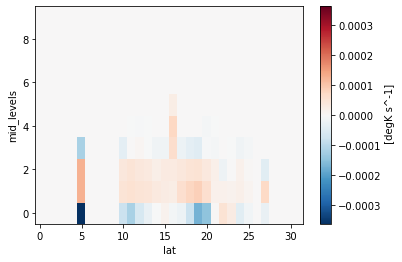

In [56]:
truth['air_temperature'].isel(lon=0).T.plot();

### Run online

How I save the files (input/output) is a little stupid for these runs, but we will run with it for now.

In [53]:
!rm inputs_rf.nc outputs_rf.nc

In [57]:
lr_model = MyModel(
    state=my_state, 
    convection=lr_convection,
    input_save_fn='./inputs_lr.nc',
    output_save_fn='./outputs_lr.nc',
)

In [59]:
lr_model.iterate(48*180)

/home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/climt/_components/simple_physics/component.py:230: RuntimeWarning: invalid value encountered in less
  latent_heat_flux[latent_heat_flux < 0] = 0


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Evaluate online runs

In [25]:
def load_data(suffix):
    inputs = xr.open_mfdataset(
        f'./inputs_{suffix}.nc', chunks={'time': 10}, combine='by_coords'
    ).transpose('time', 'mid_levels', 'lat', 'lon')
    outputs = xr.open_mfdataset(
        f'./outputs_{suffix}.nc', chunks={'time': 10}, combine='by_coords'
    ).transpose('time', 'mid_levels', 'lat', 'lon')
    outputs['time'] = inputs.time
    return xr.merge([inputs, outputs])

In [26]:
data_ref = load_data('ref')

In [27]:
data_nn = load_data('nn2')
data_rf = load_data('rf')

In [28]:
def plot_comparison(var, sl=None, mean=None, std=None):
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    dss = [data_nn, data_rf, data_ref, data_nn-data_ref, data_rf-data_ref]
    names= ['nn_preds', 'rf_preds', 'truth', 'nn_error', 'rf_error']
    for ds, n, ax in zip(dss, names, axs.flat):
        if mean is not None: ds = ds.mean(mean)
        if std is not None: ds = ds.std(std)
        ds[var].isel(sl).plot(ax=ax); ax.set_title(n)
    plt.tight_layout()

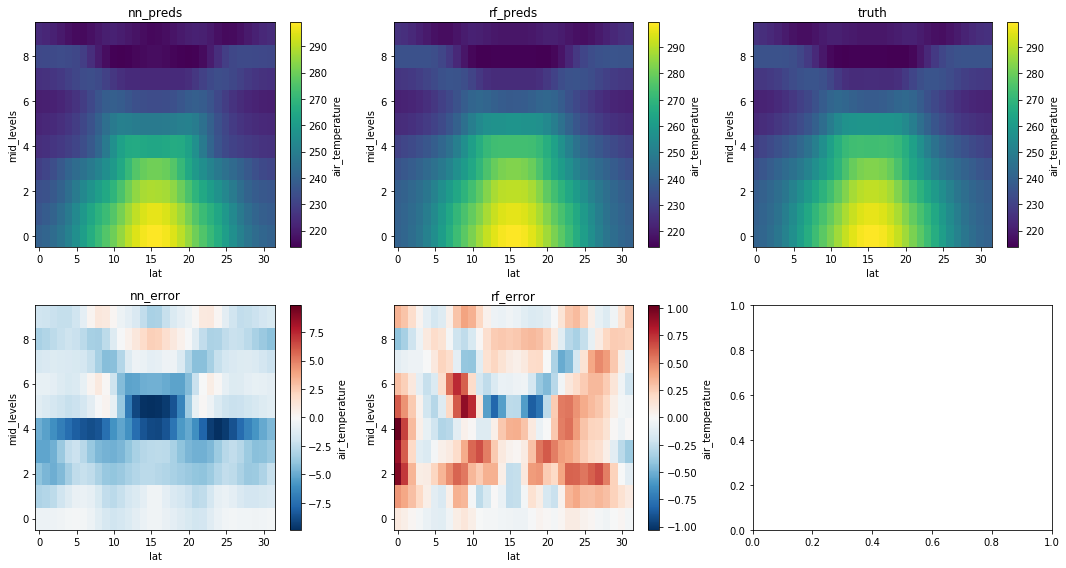

In [29]:
plot_comparison('air_temperature', mean=('time', 'lon'))

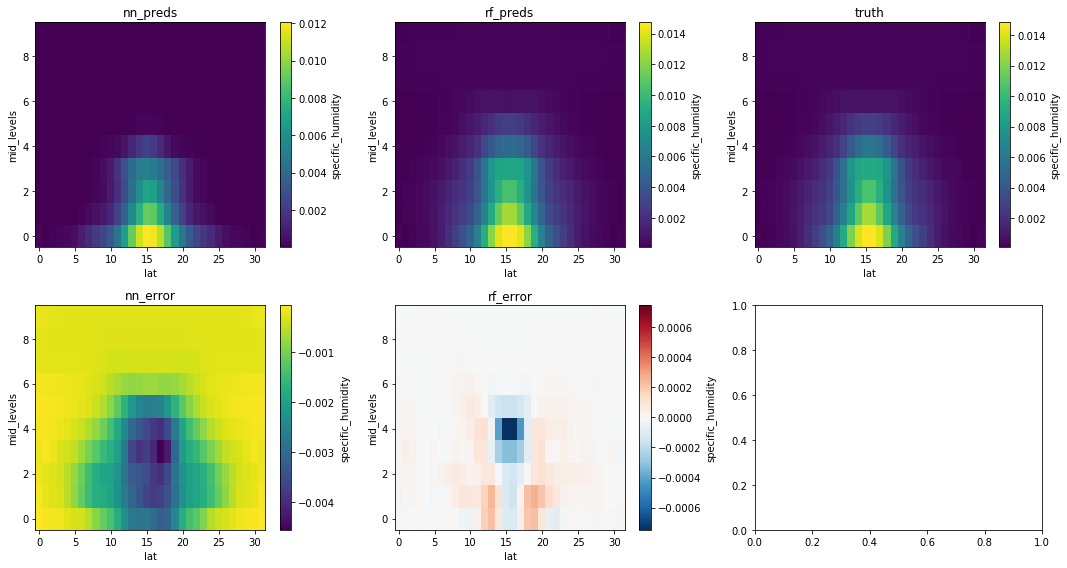

In [30]:
plot_comparison('specific_humidity', mean=('time', 'lon'))

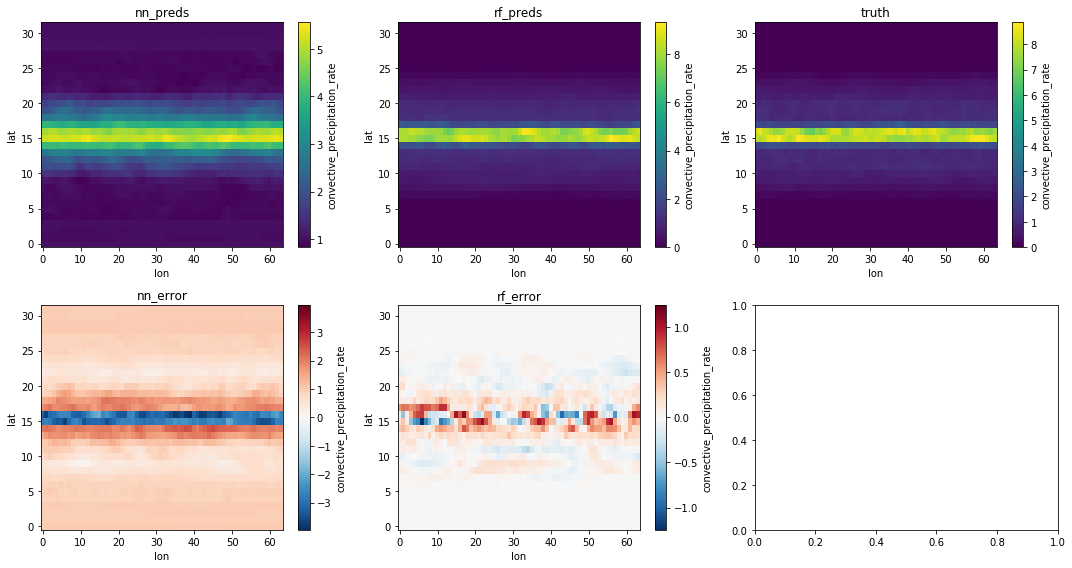

In [88]:
plot_comparison('convective_precipitation_rate', mean=('time'))

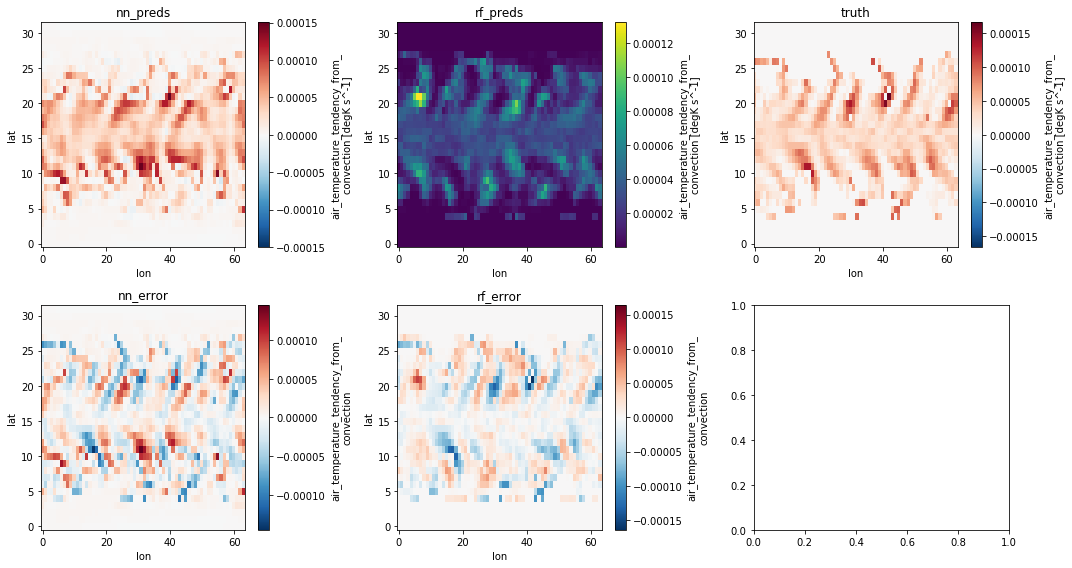

In [32]:
plot_comparison('air_temperature_tendency_from_convection', sl={'time': -1, 'mid_levels': 1})

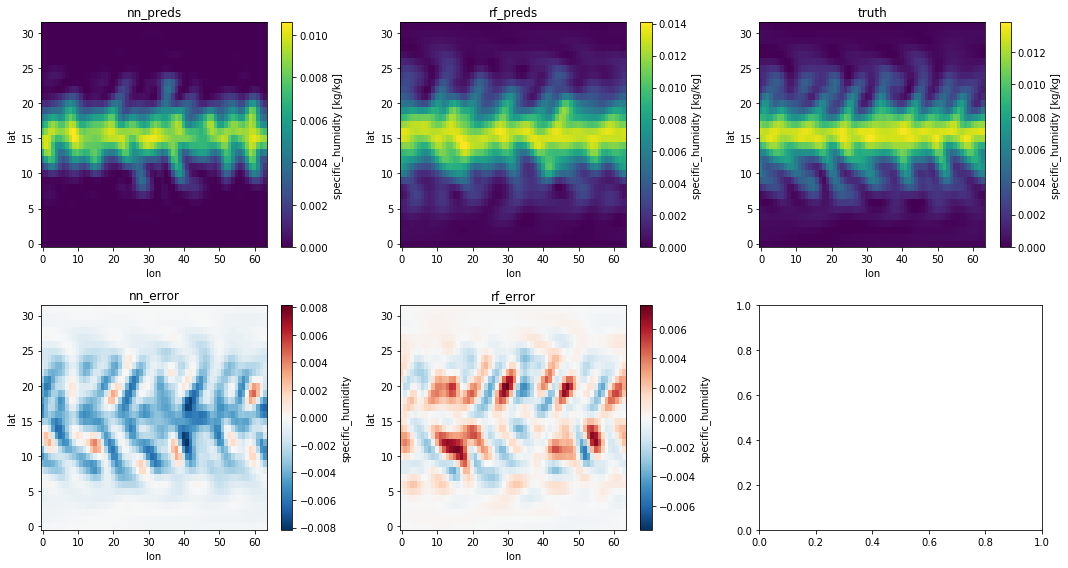

In [90]:
plot_comparison('specific_humidity', sl={'time': -1, 'mid_levels': 1})

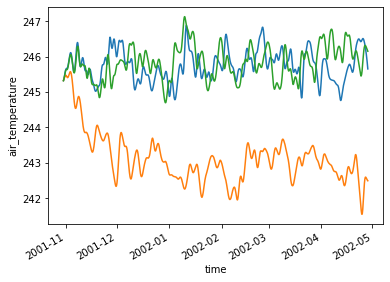

In [91]:
data_ref.air_temperature.isel(lon=0).mean(('lat', 'mid_levels')).plot()
data_nn.air_temperature.isel(lon=0).mean(('lat', 'mid_levels')).plot()
data_rf.air_temperature.isel(lon=0).mean(('lat', 'mid_levels')).plot()

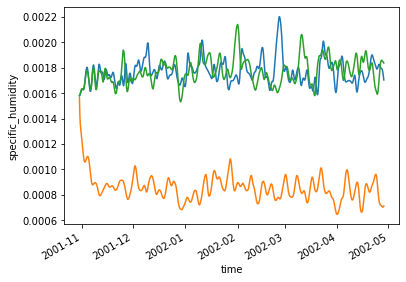

In [92]:
data_ref.specific_humidity.isel(lon=0).mean(('lat', 'mid_levels')).plot()
data_nn.specific_humidity.isel(lon=0).mean(('lat', 'mid_levels')).plot()
data_rf.specific_humidity.isel(lon=0).mean(('lat', 'mid_levels')).plot()

# Stuff

In [94]:
%load_ext line_profiler

In [98]:
test_model = MyModel(
    input_save_fn='./input_test.nc',
    output_save_fn='./output_test.nc'
)

In [108]:
from sympl import get_numpy_arrays_with_properties

In [109]:
%lprun -f get_numpy_arrays_with_properties test_model.iterate(5)

In [ ]:
# This uses a large portion of the time: quantity = state[name].to_units(properties['units'])